In [28]:
import sympy as sym
import math as m
import numpy as np
import pandas as pd


import scipy.optimize
from sympy import pprint
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import SIC_POVM_functions as sic

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [13]:
class seed_sol:
    def __init__(self, seed):
        self.seed = seed
    #defining the methods to find the solution, residuals and the sum of residuals
    def solution(self):
        solution = fsolve(Lagrange_eqs, self.initial_guess)
        return solution
    def res_list(self):
        res_list = Lagrange_eqs(self.solution())
        return res_list
    @property
    def initial_guess(self):
        np.random.seed(self.seed)
        initial_guess = np.random.rand(35)  # random initial guess
        return initial_guess
    @property
    def res(self):
        res = np.sum(np.abs(self.residuals))
        return res


In [5]:
# delta_five= [0.400000000000000, 0.433333333333333, 0.381250043028167, 0.400000000000000, 0.400000000000000, 0.383333333333333, 0.431250043028167]
delta_five  = [0.400000000000000, 0.433333333333333, 0.381250043028167, 0.400000000000000, 0.400000000000000, 0.383333333333333, 0.431250043028167]

In [6]:
def Lagrange_eqs(vars):
    # Unpacking variables, C63 to C99 and y3 to y9
    C63, C64, C65, C66, C67, C68, C69,  C73, C74, C75, C76, C77, C78, C79,  C83, C84, C85, C86, C87, C88, C89,  C93, C94, C95, C96, C97, C98, C99,  y3, y4, y5, y6, y7, y8, y9 = vars
    global delta_five
    delta_33, delta_44, delta_55, delta_66, delta_77, delta_88, delta_99 = delta_five

    # Full set of 28 equations for Cij terms, based on previous interactions
    equations = [
        # Derivatives with respect to C63 to C69
        np.conj(C63)*y3, np.conj(C63) + np.conj(C64)*y4, np.conj(C63) + np.conj(C64) + np.conj(C65)*y5, np.conj(C63) + np.conj(C64) + np.conj(C65) + np.conj(C66)*y6,
        np.conj(C63) + np.conj(C64) + np.conj(C65) + np.conj(C66) + np.conj(C67)*y7,
        np.conj(C63) + np.conj(C64) + np.conj(C65) + np.conj(C66) + np.conj(C67) + np.conj(C68)*y8,
        np.conj(C63) + np.conj(C64) + np.conj(C65) + np.conj(C66) + np.conj(C67) + np.conj(C68) + np.conj(C69)*y9,
        # Continue with C73 to C79
        
        # Derivatives with respect to C73 to C79
        np.conj(C73)*y3, np.conj(C73) + np.conj(C74)*y4, np.conj(C73) + np.conj(C74) + np.conj(C75)*y5, np.conj(C73) + np.conj(C74) + np.conj(C75) + np.conj(C76)*y6,
        np.conj(C73) + np.conj(C74) + np.conj(C75) + np.conj(C76) + np.conj(C77)*y7,
        np.conj(C73) + np.conj(C74) + np.conj(C75) + np.conj(C76) + np.conj(C77) + np.conj(C78)*y8,
        np.conj(C73) + np.conj(C74) + np.conj(C75) + np.conj(C76) + np.conj(C77) + np.conj(C78) + np.conj(C79)*y9,

        # Derivatives with respect to C83 to C89
        np.conj(C83)*y3, np.conj(C83) + np.conj(C84)*y4, np.conj(C83) + np.conj(C84) + np.conj(C85)*y5, np.conj(C83) + np.conj(C84) + np.conj(C85) + np.conj(C86)*y6,
        np.conj(C83) + np.conj(C84) + np.conj(C85) + np.conj(C86) + np.conj(C87)*y7,
        np.conj(C83) + np.conj(C84) + np.conj(C85) + np.conj(C86) + np.conj(C87) + np.conj(C88)*y8,
        np.conj(C83) + np.conj(C84) + np.conj(C85) + np.conj(C86) + np.conj(C87) + np.conj(C88) + np.conj(C89)*y9,
        # Derivatives with respect to C93 to C99
        np.conj(C93)*y3, np.conj(C93) + np.conj(C94)*y4, np.conj(C93) + np.conj(C94) + np.conj(C95)*y5, np.conj(C93) + np.conj(C94) + np.conj(C95) + np.conj(C96)*y6,
        np.conj(C93) + np.conj(C94) + np.conj(C95) + np.conj(C96) + np.conj(C97)*y7,
        np.conj(C93) + np.conj(C94) + np.conj(C95) + np.conj(C96) + np.conj(C97) + np.conj(C98)*y8,
        np.conj(C93) + np.conj(C94) + np.conj(C95) + np.conj(C96) + np.conj(C97) + np.conj(C98) + np.conj(C99)*y9,
        #Now the normalization equations
        abs(C63)**2 + abs(C73)**2 + abs(C83)**2 + abs(C93)**2 + delta_33 - 1,abs(C64)**2 + abs(C74)**2 + abs(C84)**2 + abs(C94)**2 + delta_44 - 1,
        abs(C65)**2 + abs(C75)**2 + abs(C85)**2 + abs(C95)**2 + delta_55 - 1,abs(C66)**2 + abs(C76)**2 + abs(C86)**2 + abs(C96)**2 + delta_66 - 1,
        abs(C67)**2 + abs(C77)**2 + abs(C87)**2 + abs(C97)**2 + delta_77 - 1,abs(C68)**2 + abs(C78)**2 + abs(C88)**2 + abs(C98)**2 + delta_88 - 1,
        abs(C69)**2 + abs(C79)**2 + abs(C89)**2 + abs(C99)**2 + delta_99 - 1
    ]

    assert len(equations) == 35
    return equations

# Example Usage:
initial_guess = [0.2] * 15 + [-.2]*15 + [0.1] * 5   # Initial guess for the variables (Cij real and imaginary parts, y)
solution = fsolve(Lagrange_eqs, initial_guess)
residuals = Lagrange_eqs(solution)                   # residuals and residues sum
residuals_sum = np.sum(np.abs(residuals))

print("Solution to the system:", solution)
print("Residuals:", residuals)
print("Residuals sum:", residuals_sum)

Solution to the system: [ 1.67970220e-02 -1.63237712e-02  1.70574559e-02 -1.67970220e-02
 -1.67970220e-02  1.70287160e-02  1.63537502e-02  1.68243798e-02
 -1.63503582e-02  1.70852378e-02 -1.68243798e-02 -1.68243798e-02
  1.70564512e-02  1.63803860e-02  7.74044343e-01 -7.52235888e-01
  7.86045719e-01 -7.74044343e-01 -7.74044343e-01  7.84721321e-01
  7.53617378e-01  1.70339505e-02 -1.65540244e-02  1.72980579e-02
 -1.70339505e-02 -1.70339504e-02  1.72689125e-02  1.65844257e-02
 -6.12712937e-25  1.02899151e+00 -2.77445120e-02  1.04367945e+00
  4.36794495e-02  9.43308780e-01 -5.90310284e-02]
Residuals: [-1.0291752664914375e-26, 3.642919299551295e-16, -7.043804016622357e-13, -2.1128713362239537e-11, -2.0709264056222032e-11, -2.4828090972039973e-12, -1.1790536754395509e-11, -1.0308515143749554e-26, 3.5388358909926865e-16, -7.004946210760477e-13, -2.1012247497509406e-11, -2.0588722783945745e-11, -2.467883536416693e-12, -1.1720086056168921e-11, -4.742669829629579e-25, 4.440892098500626e-16, -2.

Working. Now, conducting numerous trials using random initial points and filtering out the best outcomes. Then, converting those results into class objects for analysis.

In [17]:
seed_res_list = []
for i in range(1500):
    np.random.seed(i)
    initial_guess = np.random.rand(35)  # random initial guess
    solution = fsolve(Lagrange_eqs, initial_guess)
    residuals = Lagrange_eqs(solution)
    residuals_sum = np.sum(np.abs(residuals))
    if residuals_sum < 1e-11:
        seed_res_list.append((residuals_sum, i))
    seed_res_list.sort()            # sorted in order of increasing residue sum

seed_list = [i[1] for i in seed_res_list]   # create seed list for later use in class objects
sol_list = [seed_sol(i) for i in seed_list]  # storing class objects, list containing all good solutions as class instances

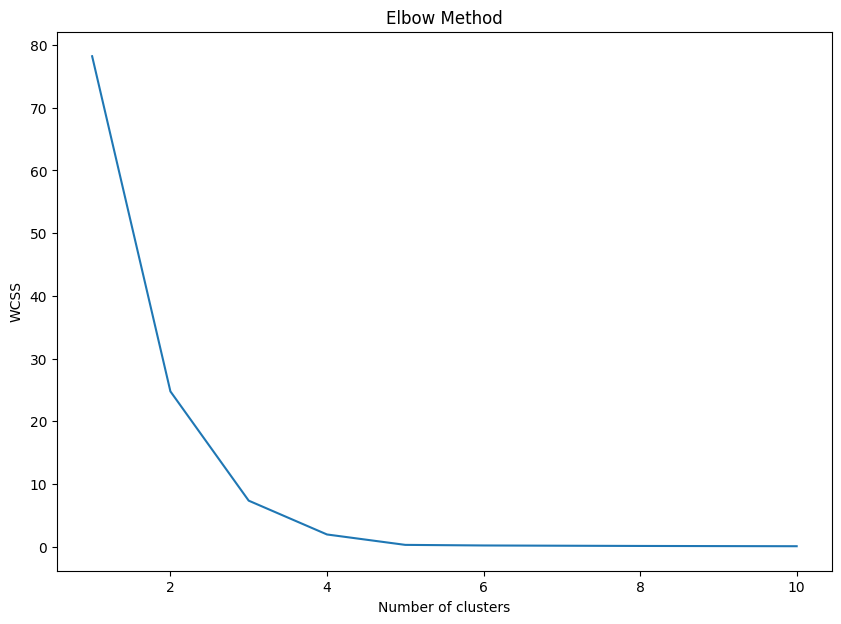

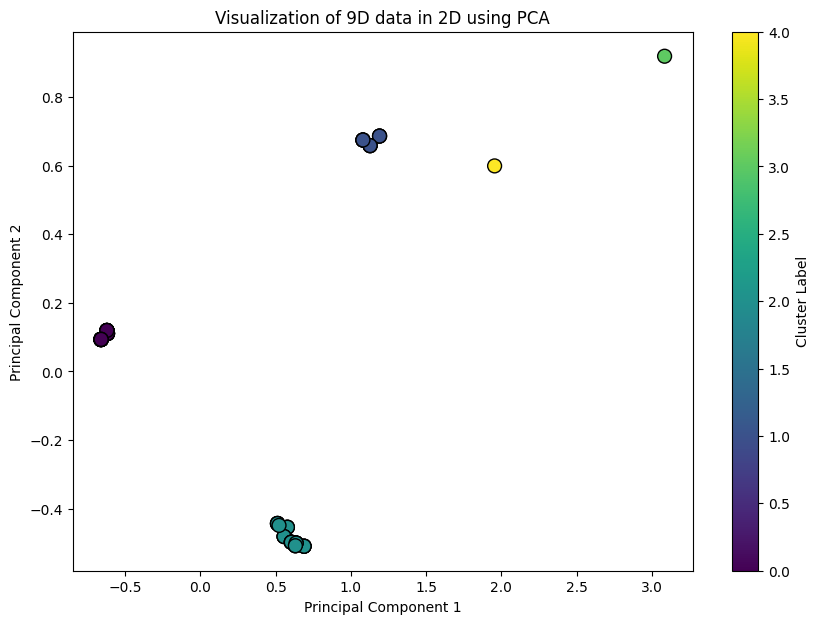

Number of centers (clusters) found: 5
Cluster 0: 55 points
Cluster 1: 11 points
Cluster 2: 30 points
Cluster 3: 1 points
Cluster 4: 1 points


In [27]:
# doing some clustering to know if the points are close by or far especially the lambda points


points = []
for i in range(len(sol_list)):
    lambdas_point = sorted(abs(sol_list[i].solution()[-7:]))
    points.append(lambdas_point)

data = points  
# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
	kmeans.fit(data)
	wcss.append(kmeans.inertia_)

# Plotting the results of the Elbow Method
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

# Choose the number of clusters based on the elbow point from the plot
# For this example, let's assume the optimal number is 3 (this should be chosen based on the plot)
optimal_clusters = 5
kmeans_optimal = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_optimal.fit(data)

# Reducing dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_optimal.labels_, cmap='viridis', edgecolor='k', s=100)
plt.title("Visualization of 9D data in 2D using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Printing the number of centers
print(f"Number of centers (clusters) found: {optimal_clusters}")

# After fitting the KMeans model to the data
labels = kmeans_optimal.labels_

# Count the number of points in each cluster
cluster_counts = np.bincount(labels)

# Print the counts
for i, count in enumerate(cluster_counts):
	print(f"Cluster {i}: {count} points")

